In [3]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from scripts.resnet_model import get_resnet18

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
img_size = 224
batch_size = 32
model_path = "models/car_resnet18_model_best.pth"
test_dir = "data_split/test"
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes

model = get_resnet18(num_classes=len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

In [6]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [8]:
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.head()

,precision,recall,f1-score,support
bumper_dent,0.777778,0.700000,0.736842,20.0
bumper_scratch,0.857143,0.750000,0.800000,24.0
door_dent,0.750000,0.620690,0.679245,29.0
door_scratch,0.689655,0.833333,0.754717,24.0
glass_shatter,0.888889,0.761905,0.820513,21.0


In [9]:
print("classification Report:\n", df_report)

classification Report:
                 precision    recall  f1-score     support
bumper_dent      0.777778  0.700000  0.736842   20.000000
bumper_scratch   0.857143  0.750000  0.800000   24.000000
door_dent        0.750000  0.620690  0.679245   29.000000
door_scratch     0.689655  0.833333  0.754717   24.000000
glass_shatter    0.888889  0.761905  0.820513   21.000000
head_lamp        0.640000  0.800000  0.711111   20.000000
tail_lamp        0.708333  0.809524  0.755556   21.000000
accuracy         0.748428  0.748428  0.748428    0.748428
macro avg        0.758828  0.753636  0.751141  159.000000
weighted avg     0.759562  0.748428  0.748854  159.000000


In [10]:
print("Accuracy Score: ", accuracy_score(all_labels, all_preds))

Accuracy Score:  0.7484276729559748


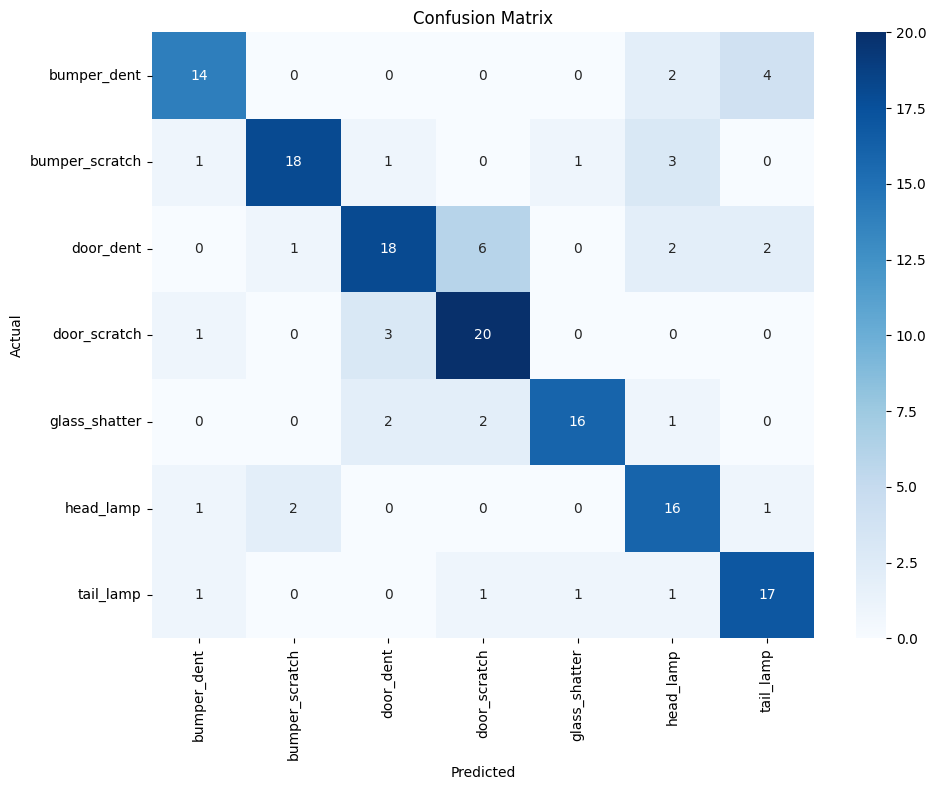

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()